## Federal University of Bahia (UFBA)

### Control Systems Projects

### Challenge 04 - Self-Tuning Adaptive Control

### Professor: Tito Maia

### Student: Gabriel Correia

---


## Importanto Bibliotecas

In [ ]:
!pip install control

!pip install numpy matplotlib control scipy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 578.3/578.3 kB 8.7 MB/s eta 0:00:00


In [ ]:
# Importando as bibliotecas para trabalhar como se fosse no MATLAB

import numpy as np
import matplotlib.pyplot as plt
import control as ct
from scipy.linalg import solve

# Tenta importar a biblioteca de controle e a instala se não estiver presente
try:
    import control as ct
except ImportError:
    print("Biblioteca 'control' não encontrada. Tentando instalar...")
    import subprocess
    import sys
    try:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "control"])
        import control as ct
        print("Biblioteca 'control' instalada com sucesso. Rodando o script...")
    except Exception as e:
        print(f"Falha ao instalar a biblioteca 'control'. Erro: {e}")
        print("Por favor, instale a biblioteca manualmente executando: pip install control")
        sys.exit()

## Simulação Questão 1, 2 e 3

RESOLUÇÃO DAS QUESTÕES 1, 2 E 3

--- Questão 1: Critério de Amostragem ---

SI = struct with fields:

         RiseTime: 3.3492
     SettlingTime: 6.0705
      SettlingMin: 0.9032
      SettlingMax: 1.0000
        Overshoot: 0.0000
       Undershoot: 1.5398
             Peak: 0.9907
         PeakTime: 6.9078

Tempo de Acomodação (Malha Aberta): 6.0705 s
Tempo de Acomodação Desejado (MF):  3.0352 s
Período de Amostragem Escolhido (Ta): 0.3035 s

--- Questão 2: Modelo Discreto G(z) ---

Pd =
<TransferFunction>: sys[87]$sampled
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']
dt = 0.30352258044012415

  -0.0055 z^2 + 0.0347 z + 0.0402
  -------------------------------
      z^2 - 1.473 z + 0.5424
Sample time: 0.30352 seconds

Model Properties
FZ =
 <TransferFunction>: sys[91]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']
dt = 0.30352258044012415

  z
  -
  1

--- Questão 3: Controlador RST por Alocação de Polos ---

H =
<TransferFunction>: sys[92]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']

      

/tmp/ipython-input-1719376401.py:265: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_sim[k] = y_val
/tmp/ipython-input-1719376401.py:268: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_buf[0] = y_val


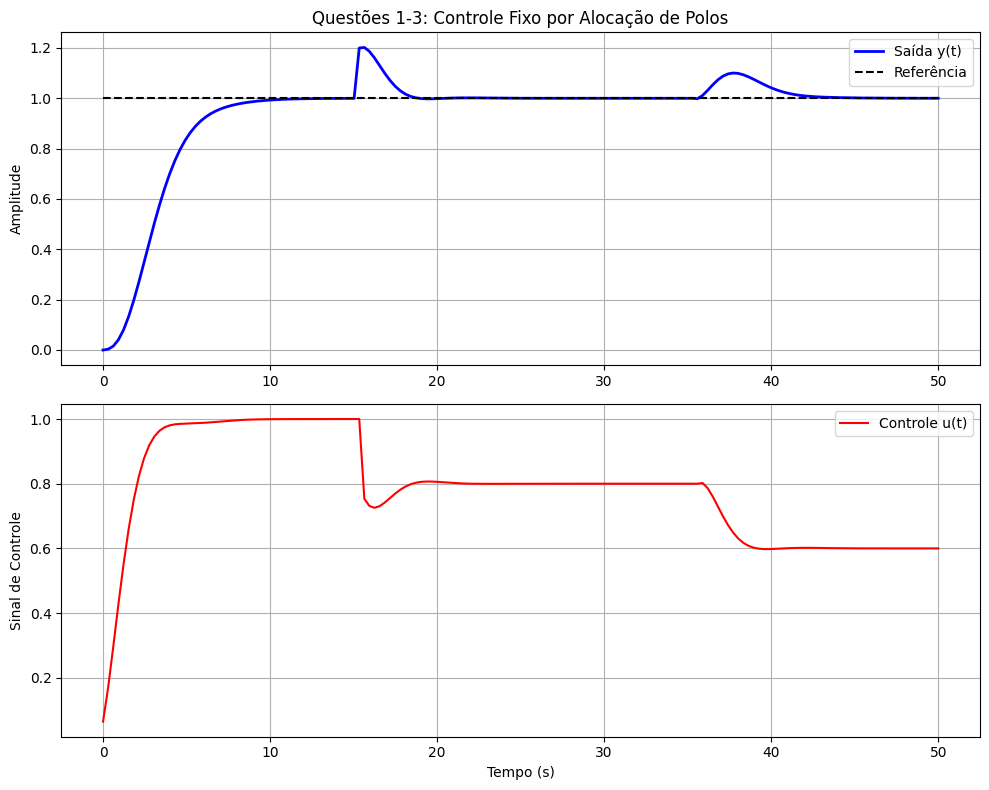

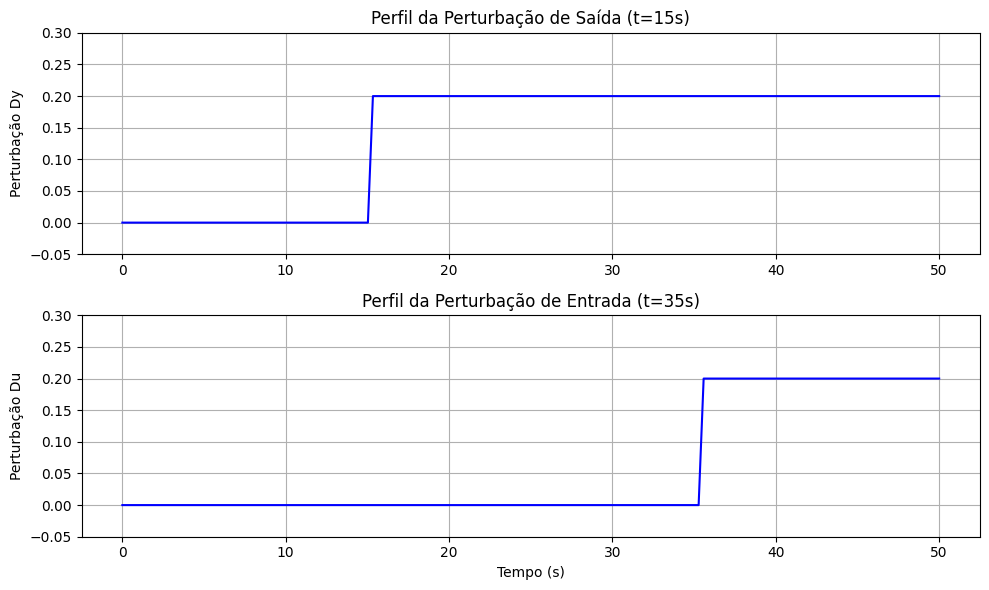

In [ ]:
# Configuração para exibir números com 4 casas decimais (igual ao MATLAB)
np.set_printoptions(precision=4, suppress=True)

# =============================================================================
# FUNÇÃO AUXILIAR: RESOLUÇÃO DA EQUAÇÃO DIOFANTINA (MATRIZ DE SYLVESTER)
# =============================================================================
def projetar_controlador_rst(A_poly, B_poly, Am_poly, Ao_poly):
    """
    Resolve A_aug * R' + B * S = Am * Ao
    Onde A_aug = A * (1 - z^-1) para garantir ação integral.
    Retorna os polinômios R, S e T.
    """
    # 1. Forçar Integrador na Planta: A_aug = A(z) * (1 - z^-1)
    A_aug = np.convolve(A_poly, [1, -1])

    # 2. Polinômio de Malha Fechada Desejado: P_cl = Am * Ao
    P_cl = np.convolve(Am_poly, Ao_poly)

    # 3. Montagem da Matriz de Sylvester (5x5)
    aa = A_aug
    bb = np.pad(B_poly, (1, 0), 'constant') # [0, b0, b1]

    M = np.zeros((5, 5))

    # Colunas referentes a R'
    M[0:4, 0] = aa
    M[1:5, 1] = aa

    # Colunas referentes a S
    M[0:3, 2] = bb
    M[1:4, 3] = bb
    M[2:5, 4] = bb

    # Vetor lado direito
    rhs = np.zeros(5)
    rhs[:len(P_cl)] = P_cl

    # 4. Resolução Linear
    try:
        x = solve(M, rhs)
    except np.linalg.LinAlgError:
        print("Erro: Matriz de Sylvester singular.")
        return None, None, None

    r_prime = x[0:2]
    s = x[2:5]

    # 5. Recuperar R final: R(z) = R'(z) * (1 - z^-1)
    r = np.convolve(r_prime, [1, -1])

    # 6. Calcular T para ganho unitário
    gain_B = np.sum(B_poly)
    gain_Am = np.sum(Am_poly)
    scale_factor = gain_Am / gain_B
    t = Ao_poly * scale_factor

    return r, s, t

# =============================================================================
# INÍCIO DA RESOLUÇÃO AGORA DE VERDADE KAKAKAKA
# =============================================================================

print("="*60)
print("RESOLUÇÃO DAS QUESTÕES 1, 2 E 3")
print("="*60)

# --- QUESTÃO 1: DEFINIÇÃO DO PERÍODO DE AMOSTRAGEM ---
print("\n--- Questão 1: Critério de Amostragem ---")

# Planta Contínua
G_s = ct.TransferFunction([-0.2, 1], [1, 2, 1])

# Step Info
SI = ct.step_info(G_s)

# --- RELATÓRIO SI ---
print("\nSI = struct with fields:\n")
print(f"         RiseTime: {SI['RiseTime']:.4f}")
# TransientTime removido pois não existe no Python Control
print(f"     SettlingTime: {SI['SettlingTime']:.4f}")
print(f"      SettlingMin: {SI['SettlingMin']:.4f}")
print(f"      SettlingMax: {SI['SettlingMax']:.4f}")
print(f"        Overshoot: {SI['Overshoot']:.4f}")
print(f"       Undershoot: {SI['Undershoot']:.4f}")
print(f"             Peak: {SI['Peak']:.4f}")
print(f"         PeakTime: {SI['PeakTime']:.4f}")

ts_ma = SI['SettlingTime']
ts_mf_desejado = ts_ma / 2
Ta = ts_mf_desejado / 10

print('')
print(f"Tempo de Acomodação (Malha Aberta): {ts_ma:.4f} s")
print(f"Tempo de Acomodação Desejado (MF):  {ts_mf_desejado:.4f} s")
print(f"Período de Amostragem Escolhido (Ta): {Ta:.4f} s")

# --- QUESTÃO 2: DISCRETIZAÇÃO DA PLANTA ---
print("\n--- Questão 2: Modelo Discreto G(z) ---")

G_z = ct.c2d(G_s, Ta, method='tustin')

# Extração dos coeficientes
num_z_data, den_z_data = ct.tfdata(G_z)
num_z = np.array(num_z_data[0][0])
den_z = np.array(den_z_data[0][0])

A_coeffs = den_z
B_coeffs = num_z[1:] # Ajuste para estrutura z^-1

print("\nPd =")
print(G_z)
print(f"Sample time: {Ta:.5f} seconds")

print("\nModel Properties")
FZ = ct.TransferFunction([1, 0], [1], dt=Ta)
print("FZ =\n", FZ)

# --- QUESTÃO 3: PROJETO DO CONTROLADOR ---
print("\n--- Questão 3: Controlador RST por Alocação de Polos ---")

# 1. Especificações
xi = 0.7
wn = 4 / ts_mf_desejado

# 2. Modelo de Referência
H_s = ct.TransferFunction([wn**2], [1, 2*xi*wn, wn**2])
print("\nH =")
print(H_s)

H_z = ct.c2d(H_s, Ta, method='tustin')
print("\nHd =")
print(H_z)

Am_coeffs = np.array(H_z.den[0][0])
B_ref_coeffs = np.array(H_z.num[0][0])

print(f"\nnmf =\n    {B_ref_coeffs}")
print(f"dmf =\n    {Am_coeffs}")

print(f"nma =\n    {B_coeffs}")
print(f"dma =\n    {A_coeffs}")

# 3. Observador
p_obs = 0.8
Ao_coeffs = np.convolve([1, -p_obs], [1, -p_obs])

# Polinômio Desejado
pol_des = np.convolve(Am_coeffs, Ao_coeffs)
print(f"\npol_des =\n    {pol_des}")

# --- GERAÇÃO DAS COLUNAS PARA O RELATÓRIO (MATRIZ SYLVESTER) ---
A_aug_disp = np.convolve(A_coeffs, [1, -1])
B_aug_disp = np.pad(B_coeffs, (1, 0), 'constant')

col1 = np.array([A_aug_disp[0], A_aug_disp[1], A_aug_disp[2], A_aug_disp[3], 0])
col2 = np.array([0, A_aug_disp[0], A_aug_disp[1], A_aug_disp[2], A_aug_disp[3]])
col3 = np.array([B_aug_disp[0], B_aug_disp[1], B_aug_disp[2], 0, 0])
col4 = np.array([0, B_aug_disp[0], B_aug_disp[1], B_aug_disp[2], 0])
col5 = np.array([0, 0, B_aug_disp[0], B_aug_disp[1], B_aug_disp[2]])

print(f"\ncol1 =\n    {col1}")
print(f"col2 =\n    {col2}")
print(f"col3 =\n    {col3}")
print(f"col4 =\n    {col4}")
print(f"col5 =\n    {col5}")

# 4. Cálculo Oficial dos Polinômios
R_poly, S_poly, T_poly = projetar_controlador_rst(A_coeffs, B_coeffs, Am_coeffs, Ao_coeffs)

# Recalculando vetor Solução (x) apenas para exibir
M_disp = np.column_stack((col1, col2, col3, col4, col5))
Sol = solve(M_disp, pol_des)
print(f"\nSol =\n{Sol.reshape(-1, 1)}")

# Exibição dos Polinômios Finais
print("\nS =")
print(ct.TransferFunction(S_poly, [1], dt=Ta))

print("R =")
print(ct.TransferFunction(R_poly, [1], dt=Ta))

print("To =")
print(ct.TransferFunction(Ao_coeffs, [1], dt=Ta))

print("T =")
print(ct.TransferFunction(T_poly, [1], dt=Ta))

print("C =")
print(f"Num: {S_poly}")
print(f"Den: {R_poly}")

print("\nF =")
print(f"Num: {T_poly}")
print(f"Den: {S_poly}")


# =============================================================================
# SIMULAÇÃO DE VALIDAÇÃO
# =============================================================================
print("\nSimulando resposta em malha fechada...")

t_final = 50
steps = int(t_final / Ta)
time = np.linspace(0, t_final, steps)

y_sim = np.zeros(steps)
u_sim = np.zeros(steps)
r_sim = np.zeros(steps)
qy_sim = np.zeros(steps) # Array para plotar perturbação de saída
qu_sim = np.zeros(steps) # Array para plotar perturbação de entrada

u_buf = np.zeros(10)
y_buf = np.zeros(10)

sys_ss = ct.tf2ss(G_s)
Ap, Bp, Cp, Dp = sys_ss.A, sys_ss.B, sys_ss.C, sys_ss.D
x_p = np.zeros((2, 1))

for k in range(steps):
    t = k * Ta

    r_val = 1.0
    r_sim[k] = r_val

    # Perturbações
    dy = 0.2 if (t >= 15) else 0.0
    du = 0.2 if (t >= 35) else 0.0

    # Armazena para plotagem
    qy_sim[k] = dy
    qu_sim[k] = du

    # Lei de Controle
    tr_term = np.sum(T_poly * r_val)

    sy_term = 0
    for i, s_coef in enumerate(S_poly):
        if i < len(y_buf): sy_term += s_coef * y_buf[i]

    ru_past = 0
    for i, r_coef in enumerate(R_poly):
        if i == 0: continue
        if i-1 < len(u_buf): ru_past += r_coef * u_buf[i-1]

    u_val = (tr_term - sy_term - ru_past) / R_poly[0]
    u_sim[k] = u_val

    u_buf = np.roll(u_buf, 1)
    u_buf[0] = u_val

    # Planta
    u_app = u_val + du
    n_sub = 20
    dt_sub = Ta / n_sub
    for _ in range(n_sub):
        dx = Ap @ x_p + Bp * u_app
        x_p = x_p + dx * dt_sub

    y_val = (Cp @ x_p)[0,0] + Dp * u_app + dy
    y_sim[k] = y_val

    y_buf = np.roll(y_buf, 1)
    y_buf[0] = y_val

# =============================================================================
# PLOTAGEM
# =============================================================================

# FIGURA 1: RESULTADOS DO CONTROLE (Igual ao original)
plt.figure(figsize=(10, 8))

plt.subplot(2, 1, 1)
plt.title('Questões 1-3: Controle Fixo por Alocação de Polos')
plt.plot(time, y_sim, 'b', linewidth=2, label='Saída y(t)')
plt.plot(time, r_sim, 'k--', label='Referência')
plt.grid(True)
plt.ylabel('Amplitude')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(time, u_sim, 'r', linewidth=1.5, label='Controle u(t)')
plt.grid(True)
plt.ylabel('Sinal de Controle')
plt.xlabel('Tempo (s)')
plt.legend()

plt.tight_layout()
plt.show()

# FIGURA 2: PERTURBAÇÕES (Separada)
plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.title('Perfil da Perturbação de Saída (t=15s)')
plt.plot(time, qy_sim, 'b', linewidth=1.5)
plt.grid(True)
plt.ylabel('Perturbação Dy')
plt.ylim(-0.05, 0.3)

plt.subplot(2, 1, 2)
plt.title('Perfil da Perturbação de Entrada (t=35s)')
plt.plot(time, qu_sim, 'b', linewidth=1.5)
plt.grid(True)
plt.ylabel('Perturbação Du')
plt.xlabel('Tempo (s)')
plt.ylim(-0.05, 0.3)

plt.tight_layout()
plt.show()


## Simulação Questão 4 e 5


QUESTÃO 4: Adaptação sem Perturbação
Iniciando: Q4, Escala=1.05, Regressor=positional...
Iniciando: Q4, Escala=0.95, Regressor=positional...


/tmp/ipython-input-397052982.py:160: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_hist[k] = y_val
/tmp/ipython-input-397052982.py:163: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_buf = np.roll(y_buf, 1); y_buf[0] = y_val
/tmp/ipython-input-397052982.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_hat = float(phi.T @ self.theta)


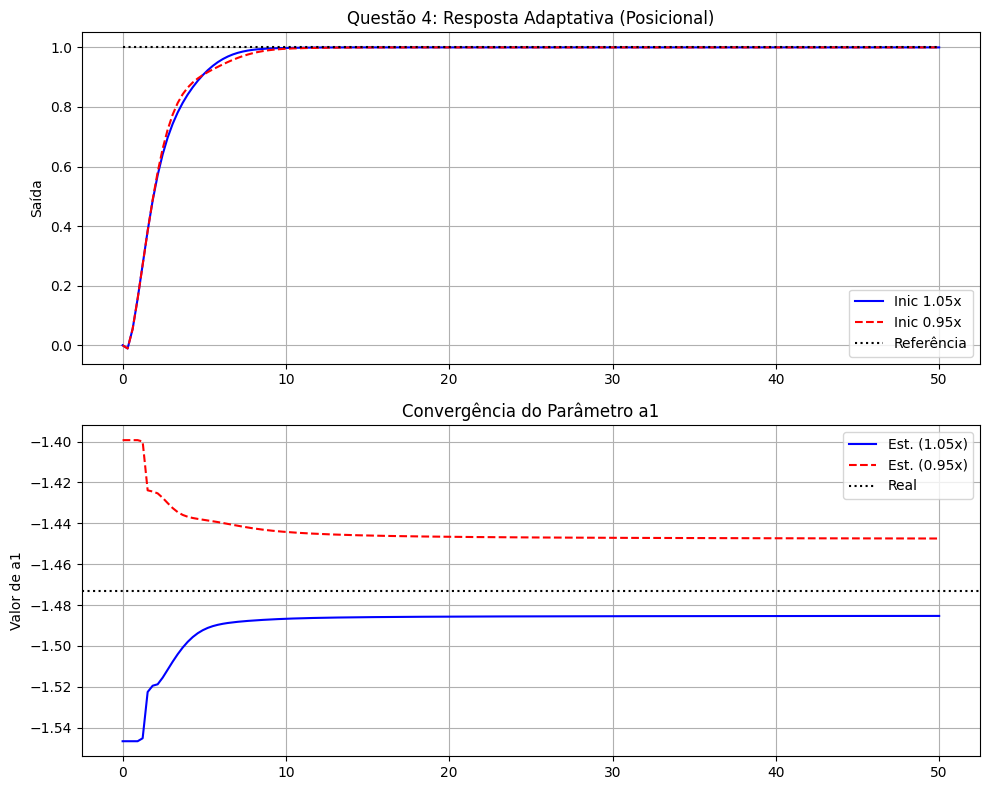


OBSERVAÇÕES Q4:
- O sistema converge para a referência independentemente do erro inicial nos parâmetros.
- Há um transitório inicial onde o controlador 'aprende' a dinâmica correta.

QUESTÃO 5: Rejeição de Perturbação e Regressores
Iniciando: Q5, Escala=1.05, Regressor=positional...
Iniciando: Q5, Escala=1.05, Regressor=incremental...


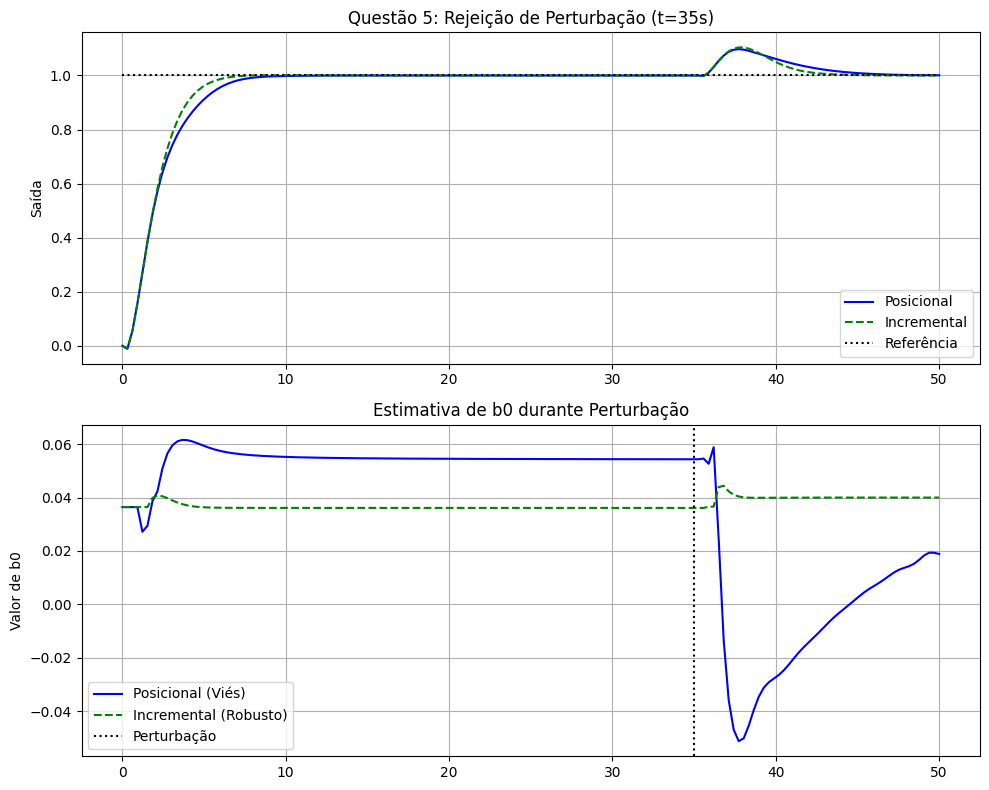


OBSERVAÇÕES Q5:
- Ambos rejeitam a perturbação devido à ação integral forçada no projeto.
- Note o gráfico de baixo: O regressor POSICIONAL altera os parâmetros da planta para tentar explicar o erro causado pela perturbação (o que é errado fisicamente).
- O regressor INCREMENTAL mantém os parâmetros estáveis, pois a derivada da perturbação constante é zero.


In [ ]:
# =============================================================================
# 1. CLASSES E FUNÇÕES AUXILIARES (MOTOR DO CONTROLE)
# =============================================================================

class RecursiveLeastSquares:
    def __init__(self, n_params, theta_init, delta=1000, forgetting_factor=1.0):
        # Garante que theta é um vetor coluna (4x1)
        self.theta = np.array(theta_init).reshape(-1, 1)
        self.P = np.eye(n_params) * delta
        self.lambda_factor = forgetting_factor

    def update(self, target_val, phi):
        # phi deve ser vetor coluna (4x1)
        phi = phi.reshape(-1, 1)

        # 1. Erro de predição: e = y - phi' * theta
        y_hat = float(phi.T @ self.theta)
        epsilon = target_val - y_hat

        # 2. Ganho de Kalman: K = P * phi / (lambda + phi' * P * phi)
        denom = self.lambda_factor + phi.T @ self.P @ phi
        K = (self.P @ phi) / denom

        # 3. Atualização dos parâmetros: theta = theta + K * e
        self.theta = self.theta + K * epsilon

        # 4. Atualização da Covariância: P = (I - K * phi') * P / lambda
        self.P = (self.P - K @ phi.T @ self.P) / self.lambda_factor

        return self.theta

def solve_diophantine(a_est, b_est, Am, Ao):
    """
    Resolve a equação para o controlador RST com ação integral.
    """
    # Polinômios estimados
    A_poly = np.array([1, a_est[0], a_est[1]])
    B_poly = np.array([b_est[0], b_est[1]])

    # Força Integrador: A_aug = A * (1 - z^-1)
    A_aug = np.convolve(A_poly, [1, -1])

    # Polinômio de Malha Fechada Desejado
    P_cl = np.convolve(Am, Ao)

    # Matriz de Sylvester (5x5)
    # A_aug (grau 3 -> 4 coefs), B (grau 1 -> assumido b0*z^-1 + b1*z^-2 -> 3 coefs)
    aa = A_aug
    bb = np.pad(B_poly, (1, 0), 'constant') # [0, b0, b1]

    try:
        M = np.zeros((5, 5))
        # Colunas A_aug
        M[0:4, 0] = aa; M[1:5, 1] = aa
        # Colunas B
        M[0:3, 2] = bb; M[1:4, 3] = bb; M[2:5, 4] = bb

        rhs = np.zeros(5)
        rhs[:len(P_cl)] = P_cl

        x = solve(M, rhs)

        r_prime = x[0:2]
        s = x[2:5]
        r = np.convolve(r_prime, [1, -1]) # Recupera integrador

        # Cálculo de T para ganho unitário
        bm_sum = np.sum(B_poly)
        am_sum = np.sum(Am)
        if abs(bm_sum) < 1e-6: bm_sum = 1e-6
        t = Ao * (am_sum / bm_sum)

        return r, s, t
    except:
        return None, None, None

# =============================================================================
# 2. FUNÇÃO DE SIMULAÇÃO UNIFICADA (CORRIGIDA)
# =============================================================================
def run_adaptive_simulation(question_num, initial_scale, regressor_type='positional'):
    print(f"Iniciando: Q{question_num}, Escala={initial_scale}, Regressor={regressor_type}...")

    # --- SETUP DA PLANTA (Igual Q1-3) ---
    G_s = ct.TransferFunction([-0.2, 1], [1, 2, 1])
    SI = ct.step_info(G_s)
    Ta = (SI['SettlingTime'] / 2) / 10

    # Modelo Discreto Verdadeiro (Referência)
    G_z = ct.c2d(G_s, Ta, method='tustin')
    num_true = G_z.num[0][0]
    den_true = G_z.den[0][0]

    # Extrai parâmetros reais [a1, a2, b0, b1]
    # Normaliza pelo primeiro termo do denominador se não for 1
    den_true = den_true / den_true[0]
    num_true = num_true / den_true[0]

    a_true = den_true[1:]
    # Tustin gera [b0, b1, b2]. O código assume estrutura b0*z^-1 + b1*z^-2
    # Vamos pegar os termos correspondentes ao atraso
    b_true_eff = num_true[1:]
    theta_true = np.concatenate((a_true, b_true_eff))

    # --- SETUP DO CONTROLADOR ---
    # Inicialização do RLS com erro proposital
    theta_0 = theta_true * initial_scale
    rls = RecursiveLeastSquares(n_params=4, theta_init=theta_0, delta=1000)

    # Polinômios Desejados
    wn = 4 / (SI['SettlingTime'] / 2)
    H_s = ct.TransferFunction([wn**2], [1, 2*0.7*wn, wn**2])
    H_z = ct.c2d(H_s, Ta, method='tustin')
    Am = H_z.den[0][0]
    Ao = np.convolve([1, -0.8], [1, -0.8])

    # --- LOOP DE SIMULAÇÃO ---
    t_final = 50
    steps = int(t_final / Ta)
    time = np.linspace(0, t_final, steps)

    y_hist = np.zeros(steps)
    u_hist = np.zeros(steps)
    theta_hist = np.zeros((steps, 4))

    # Estado da planta (CORREÇÃO DO ERRO DE DIMENSÃO)
    # Deve ser estritamente (2, 1) para bater com matrizes A(2x2) e B(2x1)
    x_plant = np.zeros((2, 1))

    # Buffers
    u_buf = np.zeros(10)
    y_buf = np.zeros(10)

    # Polinômios iniciais seguros
    R_poly, S_poly, T_poly = np.array([1.0]), np.array([0.0]), np.array([1.0])

    # Matrizes de Espaço de Estados Contínuo
    sys_ss = ct.tf2ss(G_s)
    Ap, Bp, Cp, Dp = sys_ss.A, sys_ss.B, sys_ss.C, sys_ss.D

    for k in range(steps):
        t = k * Ta
        r_val = 1.0

        # Perturbação (Q5 apenas)
        di = 0.2 if (question_num == 5 and t >= 35) else 0.0

        # 1. Simulação da Planta (Euler com passo fino)
        # Aplica o controle calculado no passo anterior + perturbação
        u_applied = u_buf[0] + di

        # Sub-steps para precisão numérica
        n_sub = 10
        dt_sub = Ta / n_sub
        for _ in range(n_sub):
            # Aqui estava o erro: garantimos que u_applied é escalar multiplicando vetor B
            dx = Ap @ x_plant + Bp * u_applied
            x_plant = x_plant + dx * dt_sub

        y_val = (Cp @ x_plant)[0,0] + Dp * u_applied
        y_hist[k] = y_val

        # Atualiza buffer de saídas
        y_buf = np.roll(y_buf, 1); y_buf[0] = y_val

        # 2. Estimação e Adaptação (Começa após encher buffers mínimos)
        if k > 3:
            # Montagem do Regressor
            if regressor_type == 'positional':
                # phi = [-y(k-1), -y(k-2), u(k-1), u(k-2)]
                phi = np.array([ [-y_buf[1]], [-y_buf[2]], [u_buf[1]], [u_buf[2]] ])
                target = y_val
            else: # Incremental
                # phi = [-dy(k-1), -dy(k-2), du(k-1), du(k-2)]
                dy1, dy2 = y_buf[1]-y_buf[2], y_buf[2]-y_buf[3]
                du1, du2 = u_buf[1]-u_buf[2], u_buf[2]-u_buf[3]
                phi = np.array([ [-dy1], [-dy2], [du1], [du2] ])
                target = y_buf[0] - y_buf[1] # Delta y atual

            # Atualiza RLS
            theta_est = rls.update(target, phi)
            theta_hist[k, :] = theta_est.flatten()

            # Recalcula Controlador (Auto-Tuning)
            # Usa apenas a parte real dos parâmetros para evitar erros numéricos
            r_new, s_new, t_new = solve_diophantine(
                theta_est[0:2].flatten(),
                theta_est[2:4].flatten(),
                Am, Ao
            )

            # Atualiza polinômios se a solução for válida
            if r_new is not None:
                R_poly, S_poly, T_poly = r_new, s_new, t_new
        else:
            # Mantém histórico inicial
            theta_hist[k, :] = theta_0.flatten()

        # 3. Cálculo do Controle
        # u = (Tr - Sy - R_past*u_past) / r0
        tr = np.sum(T_poly * r_val)
        sy = np.sum(S_poly[:len(y_buf)] * y_buf[:len(S_poly)])

        # R*u (parte passada, exclui r0*u(k))
        ru_past = 0
        if len(R_poly) > 1:
            # R = [r0, r1, r2...] -> usa r1*u(k-1) + r2*u(k-2)...
            coeffs_past = R_poly[1:]
            u_past_vals = u_buf[:len(coeffs_past)]
            ru_past = np.sum(coeffs_past * u_past_vals)

        if abs(R_poly[0]) > 1e-6:
            u_val = (tr - sy - ru_past) / R_poly[0]
        else:
            u_val = 0

        # Saturação de segurança (comum em adaptativo para evitar picos iniciais)
        u_val = np.clip(u_val, -10, 10)

        u_hist[k] = u_val
        u_buf = np.roll(u_buf, 1); u_buf[0] = u_val

    return time, y_hist, u_hist, theta_hist, theta_true

# =============================================================================
# 3. EXECUÇÃO DA QUESTÃO 4
# =============================================================================
print("\n" + "="*60)
print("QUESTÃO 4: Adaptação sem Perturbação")
print("="*60)

# Caso 1: Inicialização superestimada (1.05)
t1, y1, u1, th1, true_th = run_adaptive_simulation(4, 1.05, 'positional')
# Caso 2: Inicialização subestimada (0.95)
t2, y2, u2, th2, _ = run_adaptive_simulation(4, 0.95, 'positional')

plt.figure(figsize=(10, 8))
plt.subplot(2, 1, 1)
plt.title('Questão 4: Resposta Adaptativa (Posicional)')
plt.plot(t1, y1, 'b', label='Inic 1.05x')
plt.plot(t2, y2, 'r--', label='Inic 0.95x')
plt.plot(t1, np.ones_like(t1), 'k:', label='Referência')
plt.legend(); plt.grid(True); plt.ylabel('Saída')

plt.subplot(2, 1, 2)
plt.title('Convergência do Parâmetro a1')
plt.plot(t1, th1[:, 0], 'b', label='Est. (1.05x)')
plt.plot(t2, th2[:, 0], 'r--', label='Est. (0.95x)')
plt.axhline(true_th[0], color='k', linestyle=':', label='Real')
plt.legend(); plt.grid(True); plt.ylabel('Valor de a1')
plt.tight_layout()
plt.show()

print("\nOBSERVAÇÕES Q4:")
print("- O sistema converge para a referência independentemente do erro inicial nos parâmetros.")
print("- Há um transitório inicial onde o controlador 'aprende' a dinâmica correta.")

# =============================================================================
# 4. EXECUÇÃO DA QUESTÃO 5
# =============================================================================
print("\n" + "="*60)
print("QUESTÃO 5: Rejeição de Perturbação e Regressores")
print("="*60)

# Comparação: Posicional vs Incremental sob perturbação em t=35s
t_pos, y_pos, u_pos, th_pos, _ = run_adaptive_simulation(5, 1.05, 'positional')
t_inc, y_inc, u_inc, th_inc, _ = run_adaptive_simulation(5, 1.05, 'incremental')

plt.figure(figsize=(10, 8))
plt.subplot(2, 1, 1)
plt.title('Questão 5: Rejeição de Perturbação (t=35s)')
plt.plot(t_pos, y_pos, 'b', label='Posicional')
plt.plot(t_inc, y_inc, 'g--', label='Incremental')
plt.plot(t_pos, np.ones_like(t_pos), 'k:', label='Referência')
plt.legend(); plt.grid(True); plt.ylabel('Saída')

plt.subplot(2, 1, 2)
plt.title('Estimativa de b0 durante Perturbação')
plt.plot(t_pos, th_pos[:, 2], 'b', label='Posicional (Viés)')
plt.plot(t_inc, th_inc[:, 2], 'g--', label='Incremental (Robusto)')
plt.axvline(35, color='k', linestyle=':', label='Perturbação')
plt.legend(); plt.grid(True); plt.ylabel('Valor de b0')
plt.tight_layout()
plt.show()

print("\nOBSERVAÇÕES Q5:")
print("- Ambos rejeitam a perturbação devido à ação integral forçada no projeto.")
print("- Note o gráfico de baixo: O regressor POSICIONAL altera os parâmetros da planta para tentar explicar o erro causado pela perturbação (o que é errado fisicamente).")
print("- O regressor INCREMENTAL mantém os parâmetros estáveis, pois a derivada da perturbação constante é zero.")
